# Description

This notebook runs some pre-analyses using spectral clustering to explore the best set of parameters to cluster `umap` data version.

# Environment variables

In [1]:
from IPython.display import display

import conf

N_JOBS = conf.GENERAL["N_JOBS"]
display(N_JOBS)

3

In [2]:
%env MKL_NUM_THREADS=$N_JOBS
%env OPEN_BLAS_NUM_THREADS=$N_JOBS
%env NUMEXPR_NUM_THREADS=$N_JOBS
%env OMP_NUM_THREADS=$N_JOBS

env: MKL_NUM_THREADS=3
env: OPEN_BLAS_NUM_THREADS=3
env: NUMEXPR_NUM_THREADS=3
env: OMP_NUM_THREADS=3


# Modules loading

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
from pathlib import Path
import warnings

import numpy as np
import pandas as pd
import umap
import matplotlib.pyplot as plt
import seaborn as sns

from utils import generate_result_set_name

# Settings

In [5]:
INITIAL_RANDOM_STATE = 50000

# UMAP

In [6]:
INPUT_SUBSET = "umap"

In [7]:
INPUT_STEM = "z_score_std-projection-smultixcan-efo_partial-mashr-zscores"

In [8]:
DR_OPTIONS = {
    "n_components": 50,
    "metric": "euclidean",
    "n_neighbors": 15,
    "random_state": 0,
}

In [9]:
input_filepath = Path(
    conf.RESULTS["DATA_TRANSFORMATIONS_DIR"],
    INPUT_SUBSET,
    generate_result_set_name(
        DR_OPTIONS, prefix=f"{INPUT_SUBSET}-{INPUT_STEM}-", suffix=".pkl"
    ),
).resolve()
display(input_filepath)

assert input_filepath.exists(), "Input file does not exist"

input_filepath_stem = input_filepath.stem
display(input_filepath_stem)

PosixPath('/home/miltondp/projects/labs/greenelab/phenoplier/base3/results/data_transformations/umap/umap-z_score_std-projection-smultixcan-efo_partial-mashr-zscores-metric_euclidean-n_components_50-n_neighbors_15-random_state_0.pkl')

'umap-z_score_std-projection-smultixcan-efo_partial-mashr-zscores-metric_euclidean-n_components_50-n_neighbors_15-random_state_0'

In [10]:
data = pd.read_pickle(input_filepath)

In [11]:
data.shape

(3749, 50)

In [12]:
data.head()

,UMAP1,UMAP2,UMAP3,UMAP4,UMAP5,UMAP6,UMAP7,UMAP8,UMAP9,UMAP10,...,UMAP41,UMAP42,UMAP43,UMAP44,UMAP45,UMAP46,UMAP47,UMAP48,UMAP49,UMAP50
100001_raw-Food_weight,11.531590,10.773390,10.551500,5.689103,12.646474,8.795625,2.365859,-3.382425,1.458605,14.236823,...,2.214731,9.304909,3.359118,5.211676,1.265622,2.058685,1.291174,1.565621,7.317275,9.037535
100002_raw-Energy,11.554761,10.753816,10.548004,5.710800,12.674987,8.787647,2.379787,-3.339913,1.442655,14.196218,...,2.237087,9.270699,3.383440,5.185328,1.257113,2.057439,1.290686,1.557209,7.297037,9.009866
100003_raw-Protein,11.519615,10.786408,10.540249,5.687959,12.628188,8.789925,2.368370,-3.390937,1.464806,14.233623,...,2.216162,9.314158,3.350708,5.226166,1.267382,2.051692,1.305047,1.558942,7.307035,9.042575
100004_raw-Fat,11.515584,10.756584,10.570711,5.697041,12.661936,8.787330,2.396913,-3.351611,1.435632,14.221588,...,2.214707,9.273252,3.383349,5.220068,1.270067,2.065669,1.281447,1.578588,7.332527,9.005523
100005_raw-Carbohydrate,11.528723,10.762026,10.566773,5.698555,12.671127,8.791903,2.394764,-3.354370,1.442259,14.226301,...,2.216362,9.275563,3.383139,5.216354,1.269187,2.063429,1.280020,1.577227,7.335059,9.009464


# Clustering

In [13]:
from sklearn.cluster import SpectralClustering
from sklearn.metrics import (
    silhouette_score,
    calinski_harabasz_score
)

## `gamma` parameter

### Using default value (`gamma=1.0`)

In [14]:
with warnings.catch_warnings():
    warnings.filterwarnings('always')
    
    clus = SpectralClustering(
        eigen_solver="arpack",
#         eigen_tol=1e-3,
        n_clusters=2,
        n_init=1,
        affinity="rbf",
        gamma=1.00,
        random_state=INITIAL_RANDOM_STATE,
    )
    
    part = clus.fit_predict(data)

In [15]:
# show number of clusters and their size
pd.Series(part).value_counts()

0    3741
1       8
dtype: int64

In [16]:
# From sklearn website:
# The best value is 1 and the worst value is -1. Values near 0 indicate overlapping clusters.
# Negative values generally indicate that a sample has been assigned to the wrong cluster,
# as a different cluster is more similar
silhouette_score(data, part)

0.8465178

In [17]:
# From sklearn website:
# The score is defined as ratio between the within-cluster dispersion and the between-cluster dispersion
calinski_harabasz_score(data, part)

374.93011416107225

For default values of `gamma` (`1.0`), the algorithm works fine with this data version.

### Using `gamma>1.0` (larger than default value)

In [18]:
with warnings.catch_warnings():
    warnings.filterwarnings('always')
    
    clus = SpectralClustering(
        eigen_solver="arpack",
#         eigen_tol=1e-3,
        n_clusters=2,
        n_init=1,
        affinity="rbf",
        gamma=2.00,
        random_state=INITIAL_RANDOM_STATE,
    )
    
    part = clus.fit_predict(data)

In [19]:
# show number of clusters and their size
pd.Series(part).value_counts()

0    3741
1       8
dtype: int64

In [20]:
# From sklearn website:
# The best value is 1 and the worst value is -1. Values near 0 indicate overlapping clusters.
# Negative values generally indicate that a sample has been assigned to the wrong cluster,
# as a different cluster is more similar
silhouette_score(data, part)

0.8465178

In [21]:
# From sklearn website:
# The score is defined as ratio between the within-cluster dispersion and the between-cluster dispersion
calinski_harabasz_score(data, part)

374.93011416107225

For `gamma` values largen than the default (`1.0`), quality measures go down.

### Using `gamma<1.0` (smaller than default value)

In [22]:
with warnings.catch_warnings():
    warnings.filterwarnings('always')
    
    clus = SpectralClustering(
        eigen_solver="arpack",
#         eigen_tol=1e-3,
        n_clusters=2,
        n_init=1,
        affinity="rbf",
        gamma=0.01,
        random_state=INITIAL_RANDOM_STATE,
    )
    
    part = clus.fit_predict(data)

In [23]:
# show number of clusters and their size
pd.Series(part).value_counts()

0    3688
1      61
dtype: int64

In [24]:
# From sklearn website:
# The best value is 1 and the worst value is -1. Values near 0 indicate overlapping clusters.
# Negative values generally indicate that a sample has been assigned to the wrong cluster,
# as a different cluster is more similar
silhouette_score(data, part)

0.8607793

In [25]:
# From sklearn website:
# The score is defined as ratio between the within-cluster dispersion and the between-cluster dispersion
calinski_harabasz_score(data, part)

4641.627826464735

For `gamma` values around `0.01`, clustering quality measures change (CH improves and silhouette diminishes a little bit. I will explore more around these values.

## Extended test

In [26]:
CLUSTERING_OPTIONS = {}

CLUSTERING_OPTIONS["K_RANGE"] = [2, 4, 6, 8, 10, 20, 30, 40, 50, 60]
CLUSTERING_OPTIONS["N_REPS_PER_K"] = 5
CLUSTERING_OPTIONS["KMEANS_N_INIT"] = 10
CLUSTERING_OPTIONS["GAMMAS"] = [
    1.00,
    1e-02,
#     1e-04,
#     1e-05,
    1e-05,
#     1e-06,
#     1e-07,
#     1e-08,
#     1e-09,
    1e-10,
#     1e-11,
#     1e-12,
#     1e-13,
#     1e-14,
    1e-15,
#     1e-17,
    1e-20,
#     1e-30,
#     1e-40,
    1e-50,
]
CLUSTERING_OPTIONS["AFFINITY"] = "rbf"

display(CLUSTERING_OPTIONS)

{'K_RANGE': [2, 4, 6, 8, 10, 20, 30, 40, 50, 60],
 'N_REPS_PER_K': 5,
 'KMEANS_N_INIT': 10,
 'GAMMAS': [1.0, 0.01, 1e-05, 1e-10, 1e-15, 1e-20, 1e-50],
 'AFFINITY': 'rbf'}

In [27]:
CLUSTERERS = {}

idx = 0
random_state = INITIAL_RANDOM_STATE

for k in CLUSTERING_OPTIONS["K_RANGE"]:
    for gamma_value in CLUSTERING_OPTIONS["GAMMAS"]:
        for i in range(CLUSTERING_OPTIONS["N_REPS_PER_K"]):
            clus = SpectralClustering(
                eigen_solver="arpack",
                n_clusters=k,
                n_init=CLUSTERING_OPTIONS["KMEANS_N_INIT"],
                affinity=CLUSTERING_OPTIONS["AFFINITY"],
                gamma=gamma_value,
                random_state=random_state,
            )

            method_name = type(clus).__name__
            CLUSTERERS[f"{method_name} #{idx}"] = clus

            random_state = random_state + 1
            idx = idx + 1

In [28]:
display(len(CLUSTERERS))

350

In [29]:
_iter = iter(CLUSTERERS.items())
display(next(_iter))
display(next(_iter))

('SpectralClustering #0',
 SpectralClustering(eigen_solver='arpack', n_clusters=2, random_state=50000))

('SpectralClustering #1',
 SpectralClustering(eigen_solver='arpack', n_clusters=2, random_state=50001))

In [30]:
clustering_method_name = method_name
display(clustering_method_name)

'SpectralClustering'

## Generate ensemble

In [31]:
import tempfile
from clustering.ensemble import generate_ensemble

In [32]:
# generate a temporary folder where to store the ensemble and avoid computing it again
ensemble_folder = Path(
    tempfile.gettempdir(),
    f"pre_cluster_analysis",
    clustering_method_name,
).resolve()
ensemble_folder.mkdir(parents=True, exist_ok=True)

In [33]:
ensemble_file = Path(
    ensemble_folder,
    generate_result_set_name(CLUSTERING_OPTIONS, prefix=f"ensemble-{INPUT_SUBSET}-", suffix=".pkl")
)
display(ensemble_file)

PosixPath('/tmp/pre_cluster_analysis/SpectralClustering/ensemble-umap-AFFINITY_rbf-GAMMAS_10_001_1e_05_1e_10_1e_15_1e_20_1e_50-KMEANS_N_INIT_10-K_RANGE_2_4_6_8_10_20_30_40_50_60-N_REPS_PER_K_5.pkl')

In [34]:
if ensemble_file.exists():
    display(f"Ensemble file exists")
    ensemble = pd.read_pickle(ensemble_file)
else:
    ensemble = generate_ensemble(
        data,
        CLUSTERERS,
        attributes=["n_clusters", "gamma"],
    )
    
    ensemble.to_pickle(ensemble_file)

  0%|          | 0/350 [00:00<?, ?it/s]

  0%|          | 1/350 [00:01<09:34,  1.65s/it]

  1%|          | 2/350 [00:03<09:33,  1.65s/it]

  1%|          | 3/350 [00:04<09:13,  1.59s/it]

  1%|          | 4/350 [00:06<09:18,  1.62s/it]

  1%|▏         | 5/350 [00:08<09:20,  1.63s/it]

  2%|▏         | 6/350 [00:09<08:30,  1.48s/it]

  2%|▏         | 7/350 [00:10<07:54,  1.38s/it]

  2%|▏         | 8/350 [00:11<07:29,  1.31s/it]

  3%|▎         | 9/350 [00:12<07:11,  1.27s/it]

  3%|▎         | 10/350 [00:13<06:58,  1.23s/it]

  3%|▎         | 11/350 [00:14<06:49,  1.21s/it]

  3%|▎         | 12/350 [00:16<06:41,  1.19s/it]

  4%|▎         | 13/350 [00:17<06:36,  1.18s/it]

  4%|▍         | 14/350 [00:18<06:32,  1.17s/it]

  4%|▍         | 15/350 [00:19<06:29,  1.16s/it]

  5%|▍         | 16/350 [00:20<06:26,  1.16s/it]

  5%|▍         | 17/350 [00:21<06:25,  1.16s/it]

  5%|▌         | 18/350 [00:23<06:24,  1.16s/it]

  5%|▌         | 19/350 [00:24<06:22,  1.16s/it]

  6%|▌         | 20/350 [00:25<06:19,  1.15s/it]

  6%|▌         | 21/350 [00:26<06:19,  1.15s/it]

  6%|▋         | 22/350 [00:27<06:18,  1.15s/it]

  7%|▋         | 23/350 [00:28<06:17,  1.16s/it]

  7%|▋         | 24/350 [00:29<06:17,  1.16s/it]

  7%|▋         | 25/350 [00:31<06:16,  1.16s/it]

  7%|▋         | 26/350 [00:32<06:11,  1.15s/it]

  8%|▊         | 27/350 [00:33<06:06,  1.13s/it]

  8%|▊         | 28/350 [00:34<06:02,  1.13s/it]

  8%|▊         | 29/350 [00:35<06:04,  1.14s/it]

  9%|▊         | 30/350 [00:36<06:00,  1.13s/it]

  9%|▉         | 31/350 [00:37<06:00,  1.13s/it]

  9%|▉         | 32/350 [00:38<05:57,  1.13s/it]

  9%|▉         | 33/350 [00:40<05:54,  1.12s/it]

 10%|▉         | 34/350 [00:41<05:51,  1.11s/it]

 10%|█         | 35/350 [00:42<05:50,  1.11s/it]

 10%|█         | 36/350 [00:43<06:23,  1.22s/it]

 11%|█         | 37/350 [00:45<07:18,  1.40s/it]

 11%|█         | 38/350 [00:47<07:42,  1.48s/it]

 11%|█         | 39/350 [00:49<08:20,  1.61s/it]

 11%|█▏        | 40/350 [00:50<08:20,  1.62s/it]

 12%|█▏        | 41/350 [00:52<08:04,  1.57s/it]

 12%|█▏        | 42/350 [00:53<07:56,  1.55s/it]

 12%|█▏        | 43/350 [00:54<07:19,  1.43s/it]

 13%|█▎        | 44/350 [00:56<06:53,  1.35s/it]

 13%|█▎        | 45/350 [00:57<07:02,  1.38s/it]

 13%|█▎        | 46/350 [00:58<06:48,  1.34s/it]

 13%|█▎        | 47/350 [01:00<06:57,  1.38s/it]

 14%|█▎        | 48/350 [01:02<07:39,  1.52s/it]

 14%|█▍        | 49/350 [01:03<07:48,  1.56s/it]

 14%|█▍        | 50/350 [01:05<08:01,  1.60s/it]

 15%|█▍        | 51/350 [01:06<07:20,  1.47s/it]

 15%|█▍        | 52/350 [01:08<07:22,  1.49s/it]

 15%|█▌        | 53/350 [01:09<07:20,  1.48s/it]

 15%|█▌        | 54/350 [01:10<06:59,  1.42s/it]

 16%|█▌        | 55/350 [01:12<06:44,  1.37s/it]

 16%|█▌        | 56/350 [01:13<06:26,  1.32s/it]

 16%|█▋        | 57/350 [01:14<06:21,  1.30s/it]

 17%|█▋        | 58/350 [01:15<06:11,  1.27s/it]

 17%|█▋        | 59/350 [01:17<06:15,  1.29s/it]

 17%|█▋        | 60/350 [01:18<06:18,  1.31s/it]

 17%|█▋        | 61/350 [01:19<06:22,  1.32s/it]

 18%|█▊        | 62/350 [01:20<06:04,  1.27s/it]

 18%|█▊        | 63/350 [01:22<06:11,  1.30s/it]

 18%|█▊        | 64/350 [01:24<06:52,  1.44s/it]

 19%|█▊        | 65/350 [01:25<06:26,  1.36s/it]

 19%|█▉        | 66/350 [01:26<06:13,  1.32s/it]

 19%|█▉        | 67/350 [01:27<06:06,  1.29s/it]

 19%|█▉        | 68/350 [01:29<06:38,  1.41s/it]

 20%|█▉        | 69/350 [01:31<07:13,  1.54s/it]

 20%|██        | 70/350 [01:32<06:49,  1.46s/it]

 20%|██        | 71/350 [01:34<07:24,  1.59s/it]

 21%|██        | 72/350 [01:35<07:14,  1.56s/it]

 21%|██        | 73/350 [01:37<07:07,  1.54s/it]

 21%|██        | 74/350 [01:38<07:03,  1.54s/it]

 21%|██▏       | 75/350 [01:40<07:07,  1.55s/it]

 22%|██▏       | 76/350 [01:41<06:45,  1.48s/it]

 22%|██▏       | 77/350 [01:43<06:59,  1.54s/it]

 22%|██▏       | 78/350 [01:45<07:25,  1.64s/it]

 23%|██▎       | 79/350 [01:46<06:57,  1.54s/it]

 23%|██▎       | 80/350 [01:48<06:37,  1.47s/it]

 23%|██▎       | 81/350 [01:49<06:41,  1.49s/it]

 23%|██▎       | 82/350 [01:51<07:11,  1.61s/it]

 24%|██▎       | 83/350 [01:52<06:49,  1.54s/it]

 24%|██▍       | 84/350 [01:54<07:05,  1.60s/it]

 24%|██▍       | 85/350 [01:55<06:44,  1.53s/it]

 25%|██▍       | 86/350 [01:57<07:11,  1.63s/it]

 25%|██▍       | 87/350 [01:59<06:40,  1.52s/it]

 25%|██▌       | 88/350 [02:00<06:31,  1.49s/it]

 25%|██▌       | 89/350 [02:02<07:03,  1.62s/it]

 26%|██▌       | 90/350 [02:04<07:30,  1.73s/it]

 26%|██▌       | 91/350 [02:05<07:16,  1.68s/it]

 26%|██▋       | 92/350 [02:07<06:54,  1.61s/it]

 27%|██▋       | 93/350 [02:08<06:32,  1.53s/it]

 27%|██▋       | 94/350 [02:10<06:18,  1.48s/it]

 27%|██▋       | 95/350 [02:11<06:10,  1.45s/it]

 27%|██▋       | 96/350 [02:12<06:01,  1.42s/it]

 28%|██▊       | 97/350 [02:14<05:52,  1.39s/it]

 28%|██▊       | 98/350 [02:15<05:43,  1.36s/it]

 28%|██▊       | 99/350 [02:17<06:18,  1.51s/it]

 29%|██▊       | 100/350 [02:18<06:09,  1.48s/it]

 29%|██▉       | 101/350 [02:19<05:50,  1.41s/it]

 29%|██▉       | 102/350 [02:22<06:36,  1.60s/it]

 29%|██▉       | 103/350 [02:23<06:04,  1.48s/it]

 30%|██▉       | 104/350 [02:24<05:53,  1.44s/it]

 30%|███       | 105/350 [02:25<05:51,  1.44s/it]

 30%|███       | 106/350 [02:27<06:03,  1.49s/it]

 31%|███       | 107/350 [02:29<06:15,  1.55s/it]

 31%|███       | 108/350 [02:31<06:34,  1.63s/it]

 31%|███       | 109/350 [02:32<06:48,  1.69s/it]

 31%|███▏      | 110/350 [02:34<06:24,  1.60s/it]

 32%|███▏      | 111/350 [02:35<06:11,  1.56s/it]

 32%|███▏      | 112/350 [02:37<06:02,  1.52s/it]

 32%|███▏      | 113/350 [02:38<05:59,  1.52s/it]

 33%|███▎      | 114/350 [02:40<05:51,  1.49s/it]

 33%|███▎      | 115/350 [02:41<05:52,  1.50s/it]

 33%|███▎      | 116/350 [02:43<05:51,  1.50s/it]

 33%|███▎      | 117/350 [02:44<05:40,  1.46s/it]

 34%|███▎      | 118/350 [02:46<06:13,  1.61s/it]

 34%|███▍      | 119/350 [02:47<05:56,  1.54s/it]

 34%|███▍      | 120/350 [02:49<05:42,  1.49s/it]

 35%|███▍      | 121/350 [02:50<05:39,  1.48s/it]

 35%|███▍      | 122/350 [02:52<05:26,  1.43s/it]

 35%|███▌      | 123/350 [02:53<05:17,  1.40s/it]

 35%|███▌      | 124/350 [02:54<05:16,  1.40s/it]

 36%|███▌      | 125/350 [02:56<05:14,  1.40s/it]

 36%|███▌      | 126/350 [02:58<05:58,  1.60s/it]

 36%|███▋      | 127/350 [02:59<05:45,  1.55s/it]

 37%|███▋      | 128/350 [03:01<05:38,  1.52s/it]

 37%|███▋      | 129/350 [03:03<06:11,  1.68s/it]

 37%|███▋      | 130/350 [03:04<06:04,  1.66s/it]

 37%|███▋      | 131/350 [03:06<05:48,  1.59s/it]

 38%|███▊      | 132/350 [03:07<05:43,  1.58s/it]

 38%|███▊      | 133/350 [03:09<05:29,  1.52s/it]

 38%|███▊      | 134/350 [03:10<05:31,  1.54s/it]

 39%|███▊      | 135/350 [03:12<05:19,  1.48s/it]

 39%|███▉      | 136/350 [03:13<05:07,  1.44s/it]

 39%|███▉      | 137/350 [03:14<04:59,  1.41s/it]

 39%|███▉      | 138/350 [03:16<04:53,  1.38s/it]

 40%|███▉      | 139/350 [03:17<04:47,  1.36s/it]

 40%|████      | 140/350 [03:18<04:53,  1.40s/it]

 40%|████      | 141/350 [03:20<04:50,  1.39s/it]

 41%|████      | 142/350 [03:21<04:52,  1.41s/it]

 41%|████      | 143/350 [03:23<04:52,  1.41s/it]

 41%|████      | 144/350 [03:24<04:48,  1.40s/it]

 41%|████▏     | 145/350 [03:25<04:53,  1.43s/it]

 42%|████▏     | 146/350 [03:28<05:32,  1.63s/it]

 42%|████▏     | 147/350 [03:30<05:53,  1.74s/it]

 42%|████▏     | 148/350 [03:31<05:49,  1.73s/it]

 43%|████▎     | 149/350 [03:33<06:14,  1.86s/it]

 43%|████▎     | 150/350 [03:35<06:10,  1.85s/it]

 43%|████▎     | 151/350 [03:37<06:27,  1.95s/it]

 43%|████▎     | 152/350 [03:40<06:37,  2.01s/it]

 44%|████▎     | 153/350 [03:41<06:11,  1.89s/it]

 44%|████▍     | 154/350 [03:43<05:49,  1.78s/it]

 44%|████▍     | 155/350 [03:44<05:41,  1.75s/it]

 45%|████▍     | 156/350 [03:46<05:22,  1.66s/it]

 45%|████▍     | 157/350 [03:48<05:33,  1.73s/it]

 45%|████▌     | 158/350 [03:50<05:49,  1.82s/it]

 45%|████▌     | 159/350 [03:51<05:37,  1.77s/it]

 46%|████▌     | 160/350 [03:53<05:21,  1.69s/it]

 46%|████▌     | 161/350 [03:54<05:06,  1.62s/it]

 46%|████▋     | 162/350 [03:56<04:54,  1.57s/it]

 47%|████▋     | 163/350 [03:58<05:09,  1.65s/it]

 47%|████▋     | 164/350 [04:00<05:32,  1.79s/it]

 47%|████▋     | 165/350 [04:01<05:14,  1.70s/it]

 47%|████▋     | 166/350 [04:03<04:58,  1.62s/it]

 48%|████▊     | 167/350 [04:04<04:55,  1.61s/it]

 48%|████▊     | 168/350 [04:06<04:45,  1.57s/it]

 48%|████▊     | 169/350 [04:07<04:38,  1.54s/it]

 49%|████▊     | 170/350 [04:09<04:39,  1.55s/it]

 49%|████▉     | 171/350 [04:11<04:50,  1.63s/it]

 49%|████▉     | 172/350 [04:13<05:15,  1.77s/it]

 49%|████▉     | 173/350 [04:14<04:47,  1.63s/it]

 50%|████▉     | 174/350 [04:15<04:29,  1.53s/it]

 50%|█████     | 175/350 [04:17<04:19,  1.48s/it]

 50%|█████     | 176/350 [04:18<04:29,  1.55s/it]

 51%|█████     | 177/350 [04:20<04:34,  1.59s/it]

 51%|█████     | 178/350 [04:22<04:44,  1.65s/it]

 51%|█████     | 179/350 [04:24<05:04,  1.78s/it]

 51%|█████▏    | 180/350 [04:26<05:08,  1.81s/it]

 52%|█████▏    | 181/350 [04:28<05:27,  1.94s/it]

 52%|█████▏    | 182/350 [04:30<05:26,  1.94s/it]

 52%|█████▏    | 183/350 [04:32<05:19,  1.91s/it]

 53%|█████▎    | 184/350 [04:34<05:27,  1.97s/it]

 53%|█████▎    | 185/350 [04:36<05:34,  2.03s/it]

 53%|█████▎    | 186/350 [04:38<05:18,  1.94s/it]

 53%|█████▎    | 187/350 [04:40<05:35,  2.06s/it]

 54%|█████▎    | 188/350 [04:42<05:22,  1.99s/it]

 54%|█████▍    | 189/350 [04:44<05:24,  2.01s/it]

 54%|█████▍    | 190/350 [04:46<05:06,  1.92s/it]

 55%|█████▍    | 191/350 [04:48<05:22,  2.03s/it]

 55%|█████▍    | 192/350 [04:50<05:24,  2.05s/it]

 55%|█████▌    | 193/350 [04:52<05:11,  1.98s/it]

 55%|█████▌    | 194/350 [04:54<05:12,  2.00s/it]

 56%|█████▌    | 195/350 [04:56<04:59,  1.93s/it]

 56%|█████▌    | 196/350 [04:58<05:14,  2.04s/it]

 56%|█████▋    | 197/350 [05:00<05:07,  2.01s/it]

 57%|█████▋    | 198/350 [05:02<05:15,  2.08s/it]

 57%|█████▋    | 199/350 [05:05<05:28,  2.18s/it]

 57%|█████▋    | 200/350 [05:07<05:09,  2.07s/it]

 57%|█████▋    | 201/350 [05:08<04:57,  2.00s/it]

 58%|█████▊    | 202/350 [05:10<04:48,  1.95s/it]

 58%|█████▊    | 203/350 [05:12<04:50,  1.98s/it]

 58%|█████▊    | 204/350 [05:14<04:39,  1.92s/it]

 59%|█████▊    | 205/350 [05:16<04:43,  1.95s/it]

 59%|█████▉    | 206/350 [05:18<04:48,  2.00s/it]

 59%|█████▉    | 207/350 [05:20<04:40,  1.96s/it]

 59%|█████▉    | 208/350 [05:22<04:50,  2.05s/it]

 60%|█████▉    | 209/350 [05:25<05:02,  2.15s/it]

 60%|██████    | 210/350 [05:27<04:50,  2.07s/it]

 60%|██████    | 211/350 [05:29<05:19,  2.30s/it]

 61%|██████    | 212/350 [05:32<05:34,  2.42s/it]

 61%|██████    | 213/350 [05:35<05:38,  2.47s/it]

 61%|██████    | 214/350 [05:37<05:40,  2.50s/it]

 61%|██████▏   | 215/350 [05:40<05:56,  2.64s/it]

 62%|██████▏   | 216/350 [05:43<05:58,  2.68s/it]

 62%|██████▏   | 217/350 [05:46<05:53,  2.66s/it]

 62%|██████▏   | 218/350 [05:48<05:54,  2.69s/it]

 63%|██████▎   | 219/350 [05:51<05:53,  2.70s/it]

 63%|██████▎   | 220/350 [05:54<05:50,  2.70s/it]

 63%|██████▎   | 221/350 [05:56<05:44,  2.67s/it]

 63%|██████▎   | 222/350 [05:59<05:41,  2.67s/it]

 64%|██████▎   | 223/350 [06:02<05:37,  2.66s/it]

 64%|██████▍   | 224/350 [06:04<05:33,  2.65s/it]

 64%|██████▍   | 225/350 [06:07<05:30,  2.64s/it]

 65%|██████▍   | 226/350 [06:09<05:19,  2.58s/it]

 65%|██████▍   | 227/350 [06:12<05:16,  2.57s/it]

 65%|██████▌   | 228/350 [06:15<05:12,  2.56s/it]

 65%|██████▌   | 229/350 [06:17<05:05,  2.52s/it]

 66%|██████▌   | 230/350 [06:19<05:03,  2.53s/it]

 66%|██████▌   | 231/350 [06:22<05:10,  2.61s/it]

 66%|██████▋   | 232/350 [06:25<05:11,  2.64s/it]

 67%|██████▋   | 233/350 [06:28<05:06,  2.62s/it]

 67%|██████▋   | 234/350 [06:31<05:17,  2.74s/it]

 67%|██████▋   | 235/350 [06:33<05:14,  2.74s/it]

 67%|██████▋   | 236/350 [06:36<05:16,  2.78s/it]

 68%|██████▊   | 237/350 [06:39<05:05,  2.70s/it]

 68%|██████▊   | 238/350 [06:41<05:00,  2.68s/it]

 68%|██████▊   | 239/350 [06:44<05:05,  2.75s/it]

 69%|██████▊   | 240/350 [06:47<04:58,  2.71s/it]

 69%|██████▉   | 241/350 [06:50<05:00,  2.76s/it]

 69%|██████▉   | 242/350 [06:53<05:01,  2.80s/it]

 69%|██████▉   | 243/350 [06:56<05:07,  2.88s/it]

 70%|██████▉   | 244/350 [06:59<05:04,  2.87s/it]

 70%|███████   | 245/350 [07:01<04:59,  2.85s/it]

 70%|███████   | 246/350 [07:05<05:09,  2.97s/it]

 71%|███████   | 247/350 [07:08<05:14,  3.06s/it]

 71%|███████   | 248/350 [07:11<05:21,  3.15s/it]

 71%|███████   | 249/350 [07:15<05:21,  3.18s/it]

 71%|███████▏  | 250/350 [07:18<05:21,  3.22s/it]

 72%|███████▏  | 251/350 [07:21<05:22,  3.26s/it]

 72%|███████▏  | 252/350 [07:25<05:23,  3.30s/it]

 72%|███████▏  | 253/350 [07:28<05:22,  3.33s/it]

 73%|███████▎  | 254/350 [07:31<05:22,  3.36s/it]

 73%|███████▎  | 255/350 [07:35<05:21,  3.38s/it]

 73%|███████▎  | 256/350 [07:38<05:12,  3.32s/it]

 73%|███████▎  | 257/350 [07:41<05:03,  3.27s/it]

 74%|███████▎  | 258/350 [07:44<04:56,  3.22s/it]

 74%|███████▍  | 259/350 [07:47<04:52,  3.22s/it]

 74%|███████▍  | 260/350 [07:51<04:47,  3.20s/it]

 75%|███████▍  | 261/350 [07:54<04:36,  3.10s/it]

 75%|███████▍  | 262/350 [07:56<04:26,  3.03s/it]

 75%|███████▌  | 263/350 [07:59<04:20,  2.99s/it]

 75%|███████▌  | 264/350 [08:02<04:14,  2.96s/it]

 76%|███████▌  | 265/350 [08:05<04:10,  2.95s/it]

 76%|███████▌  | 266/350 [08:09<04:20,  3.11s/it]

 76%|███████▋  | 267/350 [08:12<04:27,  3.22s/it]

 77%|███████▋  | 268/350 [08:16<04:31,  3.31s/it]

 77%|███████▋  | 269/350 [08:19<04:29,  3.32s/it]

 77%|███████▋  | 270/350 [08:22<04:29,  3.36s/it]

 77%|███████▋  | 271/350 [08:26<04:33,  3.47s/it]

 78%|███████▊  | 272/350 [08:30<04:35,  3.54s/it]

 78%|███████▊  | 273/350 [08:33<04:27,  3.47s/it]

 78%|███████▊  | 274/350 [08:37<04:26,  3.50s/it]

 79%|███████▊  | 275/350 [08:40<04:19,  3.45s/it]

 79%|███████▉  | 276/350 [08:43<04:10,  3.39s/it]

 79%|███████▉  | 277/350 [08:47<04:10,  3.43s/it]

 79%|███████▉  | 278/350 [08:50<04:01,  3.36s/it]

 80%|███████▉  | 279/350 [08:54<04:04,  3.45s/it]

 80%|████████  | 280/350 [08:57<04:01,  3.44s/it]

 80%|████████  | 281/350 [09:01<03:58,  3.46s/it]

 81%|████████  | 282/350 [09:04<03:55,  3.46s/it]

 81%|████████  | 283/350 [09:07<03:52,  3.47s/it]

 81%|████████  | 284/350 [09:11<03:50,  3.49s/it]

 81%|████████▏ | 285/350 [09:15<03:47,  3.50s/it]

 82%|████████▏ | 286/350 [09:20<04:12,  3.95s/it]

 82%|████████▏ | 287/350 [09:24<04:23,  4.18s/it]

 82%|████████▏ | 288/350 [09:29<04:30,  4.36s/it]

 83%|████████▎ | 289/350 [09:34<04:31,  4.46s/it]

 83%|████████▎ | 290/350 [09:38<04:31,  4.52s/it]

 83%|████████▎ | 291/350 [09:45<05:10,  5.26s/it]

 83%|████████▎ | 292/350 [09:53<05:42,  5.91s/it]

 84%|████████▎ | 293/350 [10:00<05:54,  6.23s/it]

 84%|████████▍ | 294/350 [10:07<06:06,  6.54s/it]

 84%|████████▍ | 295/350 [10:15<06:14,  6.82s/it]

 85%|████████▍ | 296/350 [10:19<05:33,  6.18s/it]

 85%|████████▍ | 297/350 [10:24<05:09,  5.85s/it]

 85%|████████▌ | 298/350 [10:29<04:46,  5.51s/it]

 85%|████████▌ | 299/350 [10:34<04:30,  5.30s/it]

 86%|████████▌ | 300/350 [10:39<04:16,  5.14s/it]

 86%|████████▌ | 301/350 [10:43<03:55,  4.80s/it]

 86%|████████▋ | 302/350 [10:47<03:38,  4.55s/it]

 87%|████████▋ | 303/350 [10:50<03:24,  4.36s/it]

 87%|████████▋ | 304/350 [10:54<03:11,  4.17s/it]

 87%|████████▋ | 305/350 [10:58<03:04,  4.10s/it]

 87%|████████▋ | 306/350 [11:02<02:53,  3.94s/it]

 88%|████████▊ | 307/350 [11:06<02:48,  3.91s/it]

 88%|████████▊ | 308/350 [11:09<02:44,  3.92s/it]

 88%|████████▊ | 309/350 [11:13<02:40,  3.91s/it]

 89%|████████▊ | 310/350 [11:17<02:37,  3.94s/it]

 89%|████████▉ | 311/350 [11:21<02:31,  3.89s/it]

 89%|████████▉ | 312/350 [11:25<02:29,  3.94s/it]

 89%|████████▉ | 313/350 [11:29<02:22,  3.84s/it]

 90%|████████▉ | 314/350 [11:33<02:16,  3.80s/it]

 90%|█████████ | 315/350 [11:36<02:13,  3.81s/it]

 90%|█████████ | 316/350 [11:40<02:10,  3.83s/it]

 91%|█████████ | 317/350 [11:44<02:06,  3.84s/it]

 91%|█████████ | 318/350 [11:48<02:02,  3.84s/it]

 91%|█████████ | 319/350 [11:52<01:59,  3.85s/it]

 91%|█████████▏| 320/350 [11:56<01:57,  3.91s/it]

 92%|█████████▏| 321/350 [12:03<02:23,  4.94s/it]

 92%|█████████▏| 322/350 [12:11<02:40,  5.74s/it]

 92%|█████████▏| 323/350 [12:18<02:50,  6.31s/it]

 93%|█████████▎| 324/350 [12:26<02:52,  6.64s/it]

 93%|█████████▎| 325/350 [12:33<02:52,  6.89s/it]

 93%|█████████▎| 326/350 [12:44<03:13,  8.08s/it]

 93%|█████████▎| 327/350 [12:55<03:25,  8.93s/it]

 94%|█████████▎| 328/350 [13:06<03:30,  9.56s/it]

 94%|█████████▍| 329/350 [13:17<03:28,  9.91s/it]

 94%|█████████▍| 330/350 [13:28<03:24, 10.22s/it]

 95%|█████████▍| 331/350 [13:35<02:58,  9.37s/it]

 95%|█████████▍| 332/350 [13:42<02:35,  8.64s/it]

 95%|█████████▌| 333/350 [13:50<02:22,  8.36s/it]

 95%|█████████▌| 334/350 [13:57<02:06,  7.91s/it]

 96%|█████████▌| 335/350 [14:04<01:56,  7.74s/it]

 96%|█████████▌| 336/350 [14:08<01:31,  6.56s/it]

 96%|█████████▋| 337/350 [14:12<01:15,  5.82s/it]

 97%|█████████▋| 338/350 [14:16<01:04,  5.36s/it]

 97%|█████████▋| 339/350 [14:20<00:54,  4.97s/it]

 97%|█████████▋| 340/350 [14:25<00:47,  4.76s/it]

 97%|█████████▋| 341/350 [14:29<00:41,  4.57s/it]

 98%|█████████▊| 342/350 [14:33<00:35,  4.50s/it]

 98%|█████████▊| 343/350 [14:37<00:30,  4.39s/it]

 98%|█████████▊| 344/350 [14:41<00:26,  4.35s/it]

 99%|█████████▊| 345/350 [14:46<00:21,  4.37s/it]

 99%|█████████▉| 346/350 [14:50<00:17,  4.33s/it]

 99%|█████████▉| 347/350 [14:54<00:12,  4.30s/it]

 99%|█████████▉| 348/350 [14:59<00:08,  4.33s/it]

100%|█████████▉| 349/350 [15:03<00:04,  4.22s/it]

100%|██████████| 350/350 [15:07<00:00,  4.30s/it]

100%|██████████| 350/350 [15:07<00:00,  2.59s/it]

In [35]:
ensemble.shape

(350, 4)

In [36]:
ensemble.head()

,clusterer_params,partition,n_clusters,gamma
clusterer_id,,,,
SpectralClustering #0,"{'affinity': 'rbf', 'assign_labels': 'kmeans',...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2,1.0
SpectralClustering #1,"{'affinity': 'rbf', 'assign_labels': 'kmeans',...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2,1.0
SpectralClustering #2,"{'affinity': 'rbf', 'assign_labels': 'kmeans',...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2,1.0
SpectralClustering #3,"{'affinity': 'rbf', 'assign_labels': 'kmeans',...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2,1.0
SpectralClustering #4,"{'affinity': 'rbf', 'assign_labels': 'kmeans',...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2,1.0


In [37]:
ensemble["gamma"] = ensemble["gamma"].apply(lambda x: f"{x:.1e}")

In [38]:
ensemble["n_clusters"].value_counts()

60    35
50    35
40    35
30    35
20    35
10    35
8     35
6     35
4     35
2     35
Name: n_clusters, dtype: int64

In [39]:
_tmp = ensemble["n_clusters"].value_counts().unique()
assert _tmp.shape[0] == 1
assert _tmp[0] == int(CLUSTERING_OPTIONS["N_REPS_PER_K"] * len(CLUSTERING_OPTIONS["GAMMAS"]))

In [40]:
ensemble_stats = ensemble["n_clusters"].describe()
display(ensemble_stats)

count    350.000000
mean      23.000000
std       19.852609
min        2.000000
25%        6.000000
50%       15.000000
75%       40.000000
max       60.000000
Name: n_clusters, dtype: float64

### Testing

In [41]:
assert ensemble_stats["min"] > 1

In [42]:
assert not ensemble["n_clusters"].isna().any()

In [43]:
assert ensemble.shape[0] == len(CLUSTERERS)

In [44]:
# all partitions have the right size
assert np.all(
    [part["partition"].shape[0] == data.shape[0] for idx, part in ensemble.iterrows()]
)

In [45]:
# no partition has negative clusters (noisy points)
assert not np.any([(part["partition"] < 0).any() for idx, part in ensemble.iterrows()])

In [46]:
# check that the number of clusters in the partitions are the expected ones
_real_k_values = ensemble["partition"].apply(lambda x: np.unique(x).shape[0])
display(_real_k_values)
assert np.all(ensemble["n_clusters"].values == _real_k_values.values)

clusterer_id
SpectralClustering #0       2
SpectralClustering #1       2
SpectralClustering #2       2
SpectralClustering #3       2
SpectralClustering #4       2
                           ..
SpectralClustering #345    60
SpectralClustering #346    60
SpectralClustering #347    60
SpectralClustering #348    60
SpectralClustering #349    60
Name: partition, Length: 350, dtype: int64

### Add clustering quality measures

In [47]:
ensemble = ensemble.assign(ch_score=ensemble['partition'].apply(lambda x: calinski_harabasz_score(data, x)))

In [48]:
ensemble.shape

(350, 5)

In [49]:
ensemble.head()

,clusterer_params,partition,n_clusters,gamma,ch_score
clusterer_id,,,,,
SpectralClustering #0,"{'affinity': 'rbf', 'assign_labels': 'kmeans',...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2,1.0e+00,374.930114
SpectralClustering #1,"{'affinity': 'rbf', 'assign_labels': 'kmeans',...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2,1.0e+00,719.462482
SpectralClustering #2,"{'affinity': 'rbf', 'assign_labels': 'kmeans',...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2,1.0e+00,374.930114
SpectralClustering #3,"{'affinity': 'rbf', 'assign_labels': 'kmeans',...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2,1.0e+00,413.556449
SpectralClustering #4,"{'affinity': 'rbf', 'assign_labels': 'kmeans',...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2,1.0e+00,374.930114


# Cluster quality

In [50]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    _df = ensemble.groupby(["n_clusters", "gamma"]).mean()
    display(_df)

ch_score
n_clusters gamma               
2          1.0e+00   451.561855
           1.0e-02  4641.627826
           1.0e-05  4641.627826
           1.0e-10  4641.627826
           1.0e-15  3885.895448
           1.0e-20     2.096855
           1.0e-50     1.859119
4          1.0e+00  1692.619885
           1.0e-02  2227.943399
           1.0e-05  2778.678882
           1.0e-10  2778.678882
           1.0e-15  1272.631139
           1.0e-20     0.716896
           1.0e-50     1.356397
6          1.0e+00  1752.754447
           1.0e-02  2011.776339
           1.0e-05  1922.578744
           1.0e-10  1922.733430
           1.0e-15   628.175106
           1.0e-20     1.203606
           1.0e-50     1.733398
8          1.0e+00   659.090291
           1.0e-02  1543.156782
           1.0e-05  1530.975222
           1.0e-10  1531.529012
           1.0e-15   443.771670
           1.0e-20     1.627796
           1.0e-50     1.595965
10         1.0e+00   547.284963
           1.0e-02  1292.913866
           1.0e-05  1297.368697
           1.0e-10  1297.871898
           1.0e-15   374.314738
           1.0e-20     1.126466
           1.0e-50     1.380046
20         1.0e+00   728.463140
           1.0e-02   807.562423
           1.0e-05   768.778176
           1.0e-10   777.722528
           1.0e-15   147.423480
           1.0e-20     1.260282
           1.0e-50     1.609471
30         1.0e+00   523.341831
           1.0e-02   578.244071
           1.0e-05   560.700000
           1.0e-10   562.537906
           1.0e-15   101.280102
           1.0e-20     0.928312
           1.0e-50     0.917599
40         1.0e+00   441.616721
           1.0e-02   485.230015
           1.0e-05   456.805211
           1.0e-10   452.919083
           1.0e-15    73.308147
           1.0e-20     1.508415
           1.0e-50     1.026980
50         1.0e+00   383.221918
           1.0e-02   420.712090
           1.0e-05   369.503630
           1.0e-10   358.032117
           1.0e-15    61.070809
           1.0e-20     0.818306
           1.0e-50     1.298134
60         1.0e+00   344.417659
           1.0e-02   391.942961
           1.0e-05   301.813494
           1.0e-10   293.537717
           1.0e-15    25.735555
           1.0e-20     1.552840
           1.0e-50     1.834428

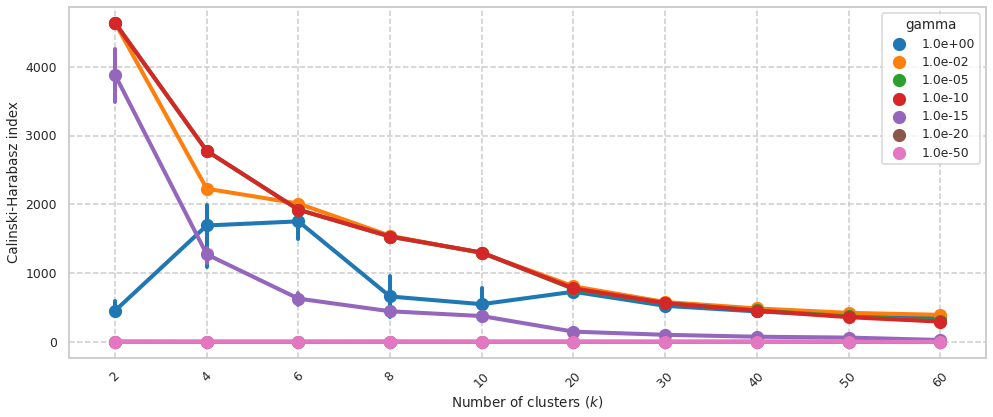

In [51]:
# with sns.axes_style('whitegrid', {'grid.linestyle': '--'}):
with sns.plotting_context("talk", font_scale=0.75), sns.axes_style(
    "whitegrid", {"grid.linestyle": "--"}
):
    fig = plt.figure(figsize=(14, 6))
    ax = sns.pointplot(data=ensemble, x="n_clusters", y="ch_score", hue="gamma")
    ax.set_ylabel("Calinski-Harabasz index")
    ax.set_xlabel("Number of clusters ($k$)")
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
    #     ax.set_ylim(0.0, 1.0)
    #     ax.set_xlim(CLUSTERING_OPTIONS['K_MIN'], CLUSTERING_OPTIONS['K_MAX'])
    plt.grid(True)
    plt.tight_layout()

# Stability

## Group ensemble by n_clusters

In [52]:
parts = ensemble.groupby(["gamma", "n_clusters"]).apply(
    lambda x: np.concatenate(x["partition"].apply(lambda x: x.reshape(1, -1)), axis=0)
)

In [53]:
parts.shape

(70,)

In [54]:
parts.head()

gamma    n_clusters
1.0e+00  2             [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
         4             [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
         6             [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
         8             [[5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0,...
         10            [[7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0,...
dtype: object

In [55]:
parts.iloc[0].shape

(5, 3749)

In [56]:
assert np.all(
    [
        parts.loc[k].shape == (
            int(CLUSTERING_OPTIONS["N_REPS_PER_K"]),
            data.shape[0]
        )
        for k in parts.index
    ]
)

## Compute stability

In [57]:
from sklearn.metrics import adjusted_rand_score as ari
from scipy.spatial.distance import squareform, pdist

In [58]:
parts_ari = pd.Series(
    {k: pdist(parts.loc[k], metric=ari) for k in parts.index}, name="n_clusters"
)

In [59]:
parts_ari_stability = parts_ari.apply(lambda x: x.mean())
display(parts_ari_stability.sort_values(ascending=False).head(15))

1.0e-05  2     1.000000
1.0e-10  4     1.000000
         2     1.000000
1.0e-02  2     1.000000
1.0e-05  4     1.000000
1.0e-02  4     0.997812
1.0e-05  10    0.990555
1.0e-10  8     0.982375
1.0e-05  6     0.982140
1.0e-10  6     0.978015
1.0e-02  8     0.975395
         6     0.953305
         10    0.902924
1.0e-15  2     0.899899
1.0e-05  8     0.893820
Name: n_clusters, dtype: float64

In [60]:
parts_ari_df = pd.DataFrame.from_records(parts_ari.tolist()).set_index(
    parts_ari.index.copy()
)
parts_ari_df.index.rename(["gamma", "n_clusters"], inplace=True)

In [61]:
parts_ari_df.shape

(70, 10)

In [62]:
_n_total_parts = int(CLUSTERING_OPTIONS["N_REPS_PER_K"])# * len(CLUSTERING_OPTIONS["GAMMAS"]))

assert (
    int( _n_total_parts * (_n_total_parts - 1) / 2 )
    == parts_ari_df.shape[1]
)

In [63]:
parts_ari_df.head()

0         1         2         3         4  \
gamma   n_clusters                                                     
1.0e+00 2           0.568279  1.000000 -0.002555  1.000000  0.568279   
        4           0.084488  0.084488  0.084488  0.084488  1.000000   
        6           1.000000  1.000000  1.000000  0.276607  1.000000   
        8           0.363849  1.000000  0.458020  0.363849  0.363849   
        10          0.456522  0.456522  1.000000  0.456522  1.000000   

                           5         6         7         8         9  
gamma   n_clusters                                                    
1.0e+00 2           0.747383  0.568279 -0.002555  1.000000 -0.002555  
        4           1.000000  1.000000  1.000000  1.000000  1.000000  
        6           1.000000  0.276607  1.000000  0.276607  0.276607  
        8           0.912533  1.000000  0.458020  0.363849  0.912533  
        10          0.456522  1.000000  0.456522  1.000000  0.456522

## Stability plot

In [64]:
parts_ari_df_plot = (
    parts_ari_df.stack()
    .reset_index()
    .rename(columns={"level_2": "idx", 0: "ari"})
)

In [65]:
parts_ari_df_plot.dtypes

gamma          object
n_clusters      int64
idx             int64
ari           float64
dtype: object

In [66]:
parts_ari_df_plot.head()

,gamma,n_clusters,idx,ari
0,1.0e+00,2,0,0.568279
1,1.0e+00,2,1,1.000000
2,1.0e+00,2,2,-0.002555
3,1.0e+00,2,3,1.000000
4,1.0e+00,2,4,0.568279


In [67]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    _df = parts_ari_df_plot.groupby(["n_clusters", "gamma"]).mean()
    display(_df)

idx       ari
n_clusters gamma                 
2          1.0e+00  4.5  0.544456
           1.0e-02  4.5  1.000000
           1.0e-05  4.5  1.000000
           1.0e-10  4.5  1.000000
           1.0e-15  4.5  0.899899
           1.0e-20  4.5  0.006633
           1.0e-50  4.5 -0.000556
4          1.0e+00  4.5  0.633795
           1.0e-02  4.5  0.997812
           1.0e-05  4.5  1.000000
           1.0e-10  4.5  1.000000
           1.0e-15  4.5  0.225563
           1.0e-20  4.5 -0.002691
           1.0e-50  4.5  0.002186
6          1.0e+00  4.5  0.710643
           1.0e-02  4.5  0.953305
           1.0e-05  4.5  0.982140
           1.0e-10  4.5  0.978015
           1.0e-15  4.5  0.079089
           1.0e-20  4.5  0.003209
           1.0e-50  4.5  0.000573
8          1.0e+00  4.5  0.619650
           1.0e-02  4.5  0.975395
           1.0e-05  4.5  0.893820
           1.0e-10  4.5  0.982375
           1.0e-15  4.5  0.083948
           1.0e-20  4.5 -0.000365
           1.0e-50  4.5  0.005254
10         1.0e+00  4.5  0.673913
           1.0e-02  4.5  0.902924
           1.0e-05  4.5  0.990555
           1.0e-10  4.5  0.876884
           1.0e-15  4.5  0.044408
           1.0e-20  4.5  0.000847
           1.0e-50  4.5 -0.003058
20         1.0e+00  4.5  0.680336
           1.0e-02  4.5  0.449127
           1.0e-05  4.5  0.469361
           1.0e-10  4.5  0.537759
           1.0e-15  4.5  0.030521
           1.0e-20  4.5  0.002186
           1.0e-50  4.5  0.001159
30         1.0e+00  4.5  0.543545
           1.0e-02  4.5  0.414316
           1.0e-05  4.5  0.414023
           1.0e-10  4.5  0.447108
           1.0e-15  4.5  0.018577
           1.0e-20  4.5 -0.002560
           1.0e-50  4.5  0.000134
40         1.0e+00  4.5  0.317496
           1.0e-02  4.5  0.352824
           1.0e-05  4.5  0.418918
           1.0e-10  4.5  0.397159
           1.0e-15  4.5  0.020857
           1.0e-20  4.5 -0.004211
           1.0e-50  4.5  0.003881
50         1.0e+00  4.5  0.270891
           1.0e-02  4.5  0.369428
           1.0e-05  4.5  0.434168
           1.0e-10  4.5  0.412429
           1.0e-15  4.5  0.029084
           1.0e-20  4.5  0.005981
           1.0e-50  4.5  0.003279
60         1.0e+00  4.5  0.324365
           1.0e-02  4.5  0.438559
           1.0e-05  4.5  0.423509
           1.0e-10  4.5  0.405138
           1.0e-15  4.5  0.024328
           1.0e-20  4.5 -0.000215
           1.0e-50  4.5 -0.002835

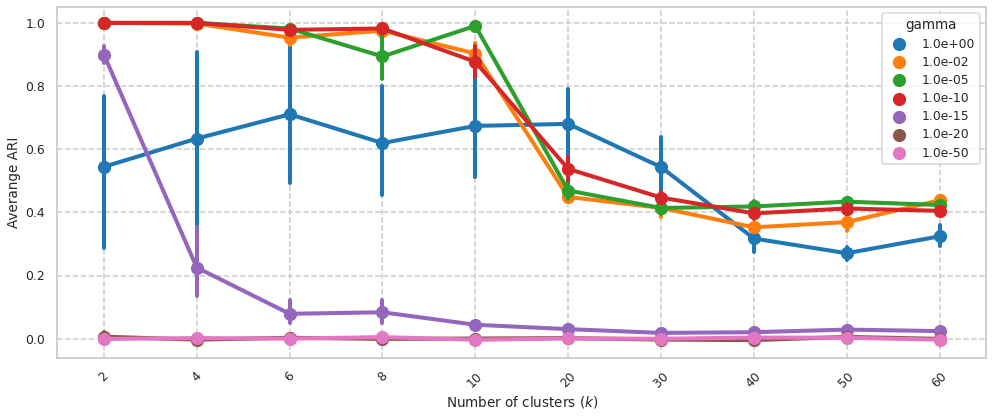

In [68]:
with sns.plotting_context("talk", font_scale=0.75), sns.axes_style(
    "whitegrid", {"grid.linestyle": "--"}
):
    fig = plt.figure(figsize=(14, 6))
    ax = sns.pointplot(data=parts_ari_df_plot, x="n_clusters", y="ari", hue="gamma")
    ax.set_ylabel("Averange ARI")
    ax.set_xlabel("Number of clusters ($k$)")
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
    plt.grid(True)
    plt.tight_layout()